# Tutorial 2: Intermediate level
Using esinet to predict sources of a sample ERP data set. 

This tutorial is based on an [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet.simulation import Simulation
from esinet.net import Net
import os

plot_params = dict(surface='white', hemi='both', verbose=0, subjects_dir=mne.datasets.sample.data_path() + '\\subjects')

In [2]:
mne.set_config('SUBJECTS_DIR', plot_params['subjects_dir'])
mne.get_config()

{'MNE_BROWSE_RAW_SIZE': '19.180555555555557,10.152777777777779',
 'MNE_DATASETS_BRAINSTORM_PATH': 'C:\\Users\\lukas\\mne_data',
 'MNE_DATASETS_SAMPLE_PATH': 'C:\\Users\\lukas\\mne_data',
 'SUBJECTS_DIR': 'C:\\Users\\lukas\\mne_data\\MNE-sample-data\\subjects'}

# Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [16]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('mag', 'eog'), baseline=baseline, reject=reject,
                    verbose=0)

fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, verbose=0)

## Visualize the sample data

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


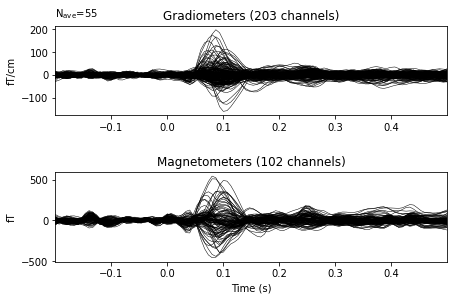

Number of events,72
Events,aud_l: 72
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


In [18]:
epochs.average().plot(verbose=0)
epochs

# Simulate Data
Artificial neural networks need training data to learn how to predict brain-electric activity (sources) given the M/EEG data. 

First, we calculate the signal to noise ratio (SNR) of our EEG data so we can adjust our simulations to it. 

In [19]:
target_snr = util.calc_snr_range(epochs, baseline_span=(-0.2, 0.0), data_span=(0.05, 0.2))
print(f'The target SNR ranges from {target_snr[0]:.2f} to {target_snr[1]:.2f}')

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
The target SNR ranges from 0.56 to 8.64


Next, we can perform the simulations with the packages default settings. Change n_samples to a smaller integer in case this cell runs for too long.

In [20]:
settings = dict(duration_of_trial=0, target_snr=target_snr, n_sources=(1, 10), extents=(2, 60), beta=1)
n_samples = 10000
simulation = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation.simulate(n_samples=n_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object

Create EEG trials with noise...


  0%|          | 0/10000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...


c:\Users\lukas\Dokumente\projects\esinet\tutorials\..\esinet\util\util.py:98: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference('average', projection=True, verbose=0)


## Visualize the simulated data
Let's visualize the simulated data and see if it looks alright. You can change the idx to another integer to visualize a different sample

In [21]:
%matplotlib qt
idx = 0

simulation.eeg_data[idx].average().plot_topomap([0.])
simulation.source_data.plot(**plot_params, initial_time=simulation.source_data.times[idx], time_viewer=False)

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


# Train the Neural Network
The Net class contains our neural network.

Using the simulations created above, we can train the neural network. This may take several minutes if you are using a CPU.

Once the training is accomplished we can perform predictions on our real data. 

In [10]:
import esinet
from esinet.net import Net
net = Net(fwd, verbose=1)  # Initialize the net object
net.fit(simulation, delta=1, false_positive_penalty=5, epochs=200)  # Train the net using our simulated eeg and source data.


Model: "net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               13184     
_________________________________________________________________
dense_3 (Dense)              (None, 7498)              967242    
Total params: 980,426
Trainable params: 980,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
71/71 [==============================] - 4s 45ms/step - loss: 0.0066 - mean_squared_error: 0.0148 - val_loss: 0.0061 - val_mean_squared_error: 0.0136
Epoch 2/200
71/71 [==============================] - 3s 42ms/step - loss: 0.0063 - mean_squared_error: 0.0140 - val_loss: 0.0059 - val_mean_squared_error: 0.0130
Epoch 3/200
71/71 [==============================] - 3s 43ms/step - loss: 0.0061 - mean_squared_error: 0.0134 - val_loss: 0.0058 - val_mean_squared_error: 0.0126
Epoch 4/200
71/71 [============

# Evaluate the ANN
Lets simulate some more data which the neural network has not seen yet to test whether it works!

In [11]:
# Simulate new, unseen test data.
n_samples = 100
simulation_test = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation_test.simulate(n_samples=n_samples)
# Predict source from EEG
source_hat = net.predict(simulation_test)

# Plot Ground Truth
source = simulation_test.source_data
a = source.plot(**plot_params)

# Plot Prediction
b = source_hat.plot(**plot_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object

Create EEG trials with noise...


  0%|          | 0/100 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...


c:\Users\lukas\Dokumente\projects\esinet\tutorials\..\esinet\util\util.py:98: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference('average', projection=True, verbose=0)
C:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [3.04272998 3.64514405 7.79105629]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.5534637  1.05636148 3.91345796]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [3.04272998 3.64514405 7.79105629]
Using control points [0.5534637  1.05636148 3.91345796]
Using control points [0.5534637  1.05636148 3.91345796]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.18570497 0.96779842 9.95501455]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.64108733 1.19761688 3.29922433]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.         0.         2.00204145]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [6.63001115e-16 6.15935669e-10 8.62241403e+00]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [4.92902324 4.92902425 5.45463378]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.9961923  1.57212091 4.62945375]
Using control points [1.77565151e-15 5.04373461e-05 8.21935335e+00]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.23718356 0.3767508  1.21971213]
Using control points [0. 0. 0.]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.         0.         0.34770074]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [4.37187065e-05 4.86316310e+00 4.86316310e+00]
Using control points [0.         0.         2.56064853]


# Estimate sources from real data
Using ANN

In [13]:
stc = net.predict(epochs.average())
stc.plot(**plot_params)

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


C:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Using control points [0.00000000e+00 0.00000000e+00 7.18531223e-09]
Using control points [0.00000000e+00 1.99403843e-10 1.27535346e-09]


...using eLORETA

In [17]:
raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014')

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('meg', 'eog'), baseline=baseline, reject=reject)
evoked = epochs.average().pick('meg')
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)



# method = "eLORETA"
# snr = 3.
# lambda2 = 1. / snr ** 2
# noise_cov = mne.compute_covariance(
#     epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

# inverse_operator = mne.minimum_norm.make_inverse_operator(
#     epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)
    
# stc_elor, residual = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2,
#                               method=method, pick_ori=None,
#                               return_residual=True, verbose=True)
# stc_elor.plot(**plot_params)


Opening raw data file C:\Users\lukas\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


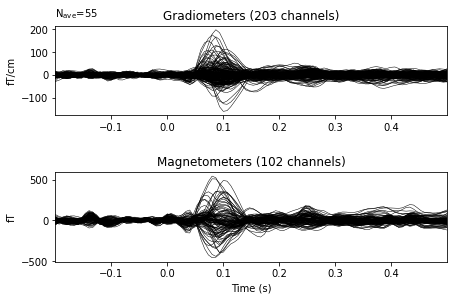

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


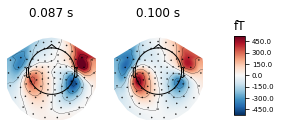

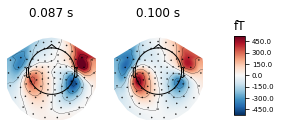

  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.72999433e-10 1.99174899e-10 3.37319502e-10]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.00000000e+00 0.00000000e+00 5.82075718e-09]


In [15]:
epochs.average().plot()
epochs.average().plot_topomap([0.087, 0.1])


In [ ]:
epochs.load_data()
epochs_stripped = epochs.copy().pick_types(meg=True)
fwd_stripped = fwd.copy().pick_channels(epochs_stripped.ch_names)
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

evoked_hat = util.get_eeg_from_source(stc, fwd_fixed, epochs_stripped.info, tmin=-0.2)
evoked_hat.plot()
evoked_hat.plot_topomap([0.087, 0.1])

In [ ]:


fwd_stripped = fwd.copy().pick_channels(epochs.copy().pick_types(meg=True).ch_names)

def select_channels_of_forward_model(fwd, info):
    return fwd.copy().pick_channels(epochs.copy().pick(info.ch_names).ch_names)